In [1]:
import duckdb
import pandas as pd
import os

PAI_DIR = os.getcwd()  # diretório atual para notebooks jupyter
DATA_RAW = os.path.join(PAI_DIR, "data", "raw")
DATA_PROCESSED = os.path.join(PAI_DIR, "data", "processed")
SCRIPTS = os.path.join(PAI_DIR, "scripts")

pd.set_option("display.float_format", "{:,.0f}".format)

In [2]:
!python {os.path.join(SCRIPTS, 'elt_precatorios.py')}

✅ Arquivo salvo: c:\Users\00526862130\Projetos\sefin_geop\notebooks\data\raw\precatorios.parquet


c:\Users\00526862130\Projetos\sefin_geop\notebooks\scripts\gerar_parquet.py:20: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  return pd.read_sql(sql, con=connection)


In [2]:
con = duckdb.connect(database=':memory:')

In [7]:
caminho = os.path.join(DATA_RAW, 'precatorios.parquet')
nome_tabela = 'precatorios'
con.execute(f"""
    CREATE TABLE IF NOT EXISTS {nome_tabela} AS
    SELECT * FROM '{caminho}'
""")

df_precatorios = con.execute(f"SELECT * FROM {nome_tabela}").df()

df_precatorios.head(2)

,SIGEF_DB,NUSEQ,CDUNIDADEGESTORAORIGEM,CDGESTAOORIGEM,CDGESTAODESTINO,CDUNIDADEGESTORADESTINO,CDCONTACONTABIL,CDEVENTO,NUCONTACORRENTE,NUDOCUMENTO,...,CDNATUREZADESPESACC,CDGRUPOPROGFINCC,CDCONTRATOEMPRESTIMOCC,CDPARCELACONTRATOEMPCC,CDNATUREZADESPESADETCC,CDTIPOCREDORCC,NUMESCC,NURETENCAOCC,NUDOCUMENTOCC,CT_CARGA_EM
0,SIGEF2024,212229,140099,1,1,140099,79820000000,540905,None,2024NL002248,...,<NA>,<NA>,<NA>,<NA>,<NA>,None,<NA>,<NA>,<NA>,2025-03-13 19:21:00.313116
1,SIGEF2024,212230,140099,1,1,140099,89823010000,540905,090077,2024NL002248,...,<NA>,<NA>,<NA>,<NA>,<NA>,1,<NA>,<NA>,<NA>,2025-03-13 19:21:00.313116


In [8]:
df_precatorios = con.execute("""
            SELECT
                SUBSTRING(SIGEF_DB, 6, 4) AS ANO,
                EXTRACT(MONTH FROM DTREFERENCIA) AS MES,
                SUM(CASE WHEN FLESTORNO = 0 THEN VLLANCAMENTO ELSE -VLLANCAMENTO END) AS VALOR
            FROM precatorios
            WHERE INSINAL = 'C' 
            GROUP BY 1,2
            ORDER BY 1,2
            """).df()

In [40]:
df_precatorios

,ANO,MES,VALOR
0,2022,3,"24,000,000"
1,2022,4,"24,710,333"
2,2022,5,"11,722,617"
3,2022,6,"12,075,475"
4,2022,7,"12,539,877"
5,2022,8,"12,884,343"
6,2022,9,"19,734,553"
7,2022,10,"19,823,465"
8,2022,11,"19,902,245"
9,2022,12,"20,040,801"


In [41]:
df_precatorios.describe()

,MES,VALOR
count,41,41
mean,6,"27,250,748"
std,3,"6,558,912"
min,1,"11,722,617"
25%,4,"26,240,182"
50%,6,"27,272,176"
75%,9,"32,296,610"
max,12,"35,107,879"


In [13]:
import matplotlib.pyplot as plt

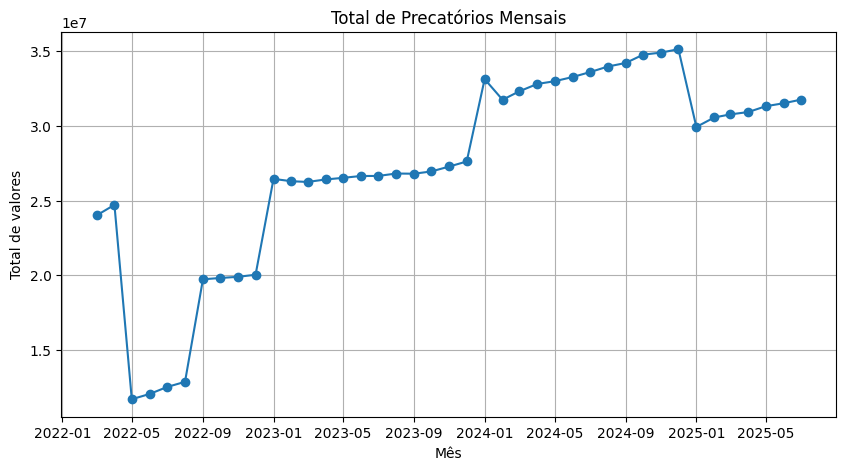

In [14]:
df_precatorios['DATA'] = pd.to_datetime(
	df_precatorios.rename(columns={'ANO': 'year', 'MES': 'month'})[['year', 'month']].assign(day=1)
)

plt.figure(figsize=(10,5))
plt.plot(df_precatorios['DATA'], df_precatorios['VALOR'], marker='o')
plt.title("Total de Precatórios Mensais")
plt.xlabel("Mês")
plt.ylabel("Total de valores")
plt.grid(True)
plt.show()

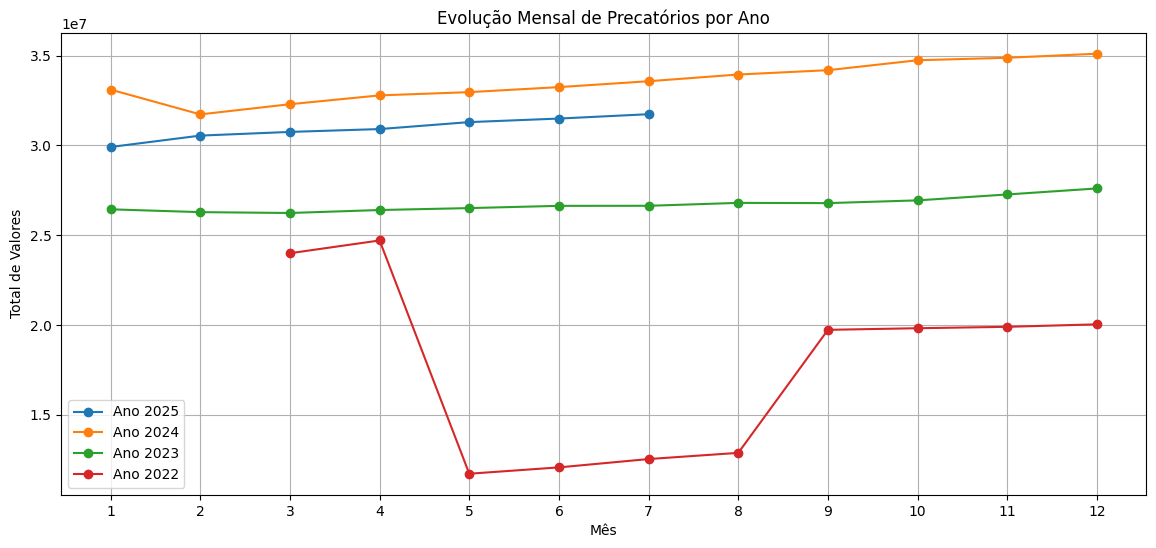

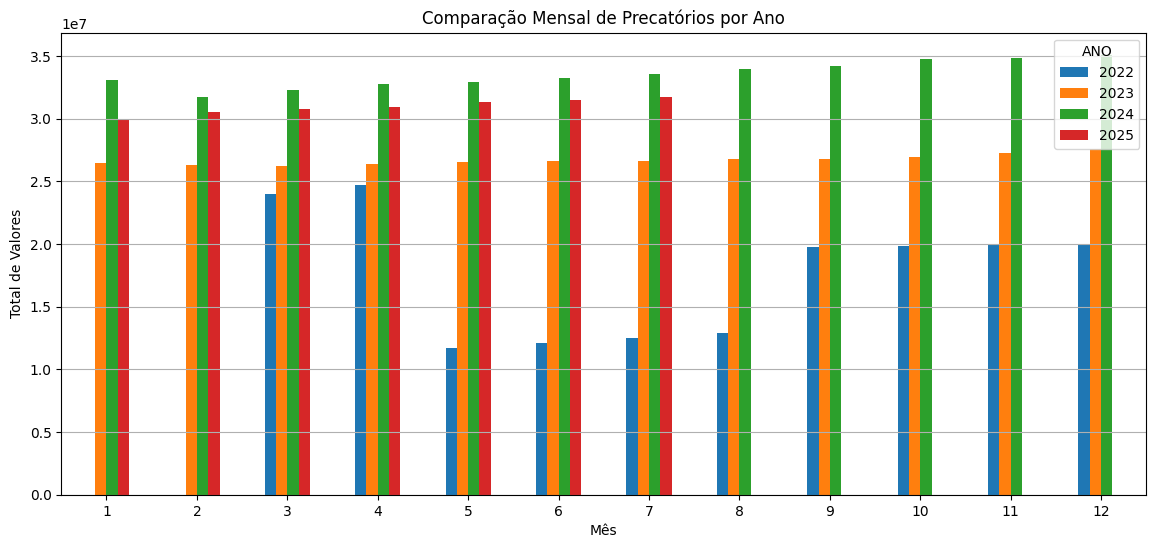

C:\Users\00526862130\AppData\Local\Temp\ipykernel_28456\2511188866.py:36: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  df_var = df_pivot.pct_change(axis=1) * 100


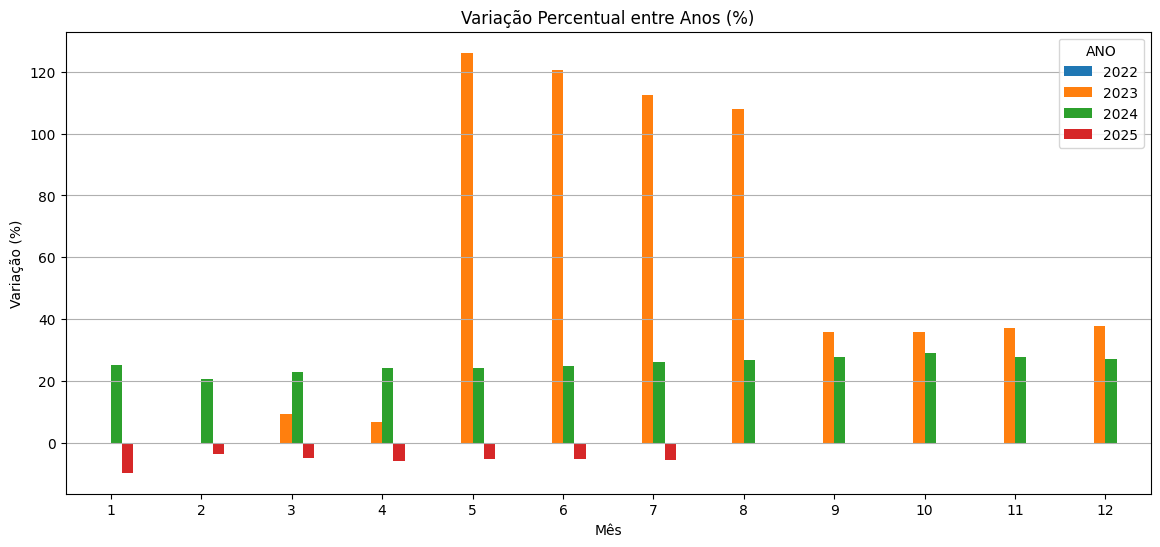

In [26]:
# Extraindo ano e mês para conveniência
df_precatorios['ANO'] = df_precatorios['DATA'].dt.year
df_precatorios['MES'] = df_precatorios['DATA'].dt.month

anos = sorted(df_precatorios['ANO'].unique(), reverse=True)
meses = range(1,13)

plt.figure(figsize=(14,6))

# ---- Linha de evolução mensal por ano ----
for ano in anos:
    df_ano = df_precatorios[df_precatorios['ANO'] == ano]
    plt.plot(df_ano['MES'], df_ano['VALOR'], marker='o', label=f"Ano {ano}")

plt.title("Evolução Mensal de Precatórios por Ano")
plt.xlabel("Mês")
plt.ylabel("Total de Valores")
plt.xticks(meses)
plt.grid(True)
plt.legend()
plt.show()

# ---- Comparação de barras entre anos ----
df_pivot = df_precatorios.pivot(index='MES', columns='ANO', values='VALOR')
df_pivot.plot(kind='bar', figsize=(14,6))
plt.title("Comparação Mensal de Precatórios por Ano")
plt.xlabel("Mês")
plt.ylabel("Total de Valores")
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.show()

# ---- Variação percentual mês a mês entre anos ----
# Exemplo: ano mais recente vs anterior
if len(anos) > 1:
    df_var = df_pivot.pct_change(axis=1) * 100
    df_var.plot(kind='bar', figsize=(14,6))
    plt.title("Variação Percentual entre Anos (%)")
    plt.xlabel("Mês")
    plt.ylabel("Variação (%)")
    plt.xticks(rotation=0)
    plt.grid(axis='y')
    plt.show()

In [3]:
import requests

In [38]:
#https://apisidra.ibge.gov.br/
#https://apisidra.ibge.gov.br/home/ajuda

url = "https://apisidra.ibge.gov.br/values/h/n/t/7060//n1/1/p/all?formato=json"

response = requests.get(url)
data = response.json()

df = pd.DataFrame(data)

df = df[['D1N', 'D2C', 'D3N', 'V', 'MN']]
df.columns = ['brasil', 'periodo', 'indicador', 'valor', 'unidade']

# Converter a coluna 'Valor' para float, tratando possíveis valores inválidos
df['valor'] = pd.to_numeric(df['valor'], errors='coerce')

df['valor'] = df['valor'].round(2)

df['periodo'] = pd.to_datetime(df['periodo'], format='%Y%m')


df['ano'] = df['periodo'].dt.year
df['mes'] = df['periodo'].dt.month


df = df.drop(columns=['periodo'])


df.to_parquet(os.path.join(DATA_RAW, 'inflacao_ipca.parquet'), index=False)

ConnectionError: ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response'))

In [5]:
caminho = os.path.join(DATA_RAW, 'inflacao_ipca.parquet')
nome_tabela = 'inflacao_ipca'
con.execute(f"""
    CREATE TABLE IF NOT EXISTS {nome_tabela} AS
    SELECT * FROM '{caminho}'
""")

In [36]:
inflacao_ipca = con.execute("""
            SELECT * FROM inflacao_ipca where indicador = 'IPCA - Variação acumulada em 12 meses'
""").df()

inflacao_ipca

,brasil,indicador,valor,unidade,ano,mes
0,Brasil,IPCA - Variação acumulada em 12 meses,NaN,,2020,1
1,Brasil,IPCA - Variação acumulada em 12 meses,NaN,,2020,2
2,Brasil,IPCA - Variação acumulada em 12 meses,NaN,,2020,3
3,Brasil,IPCA - Variação acumulada em 12 meses,NaN,,2020,4
4,Brasil,IPCA - Variação acumulada em 12 meses,NaN,,2020,5
...,...,...,...,...,...,...
62,Brasil,IPCA - Variação acumulada em 12 meses,5,%,2025,3
63,Brasil,IPCA - Variação acumulada em 12 meses,6,%,2025,4
64,Brasil,IPCA - Variação acumulada em 12 meses,5,%,2025,5
65,Brasil,IPCA - Variação acumulada em 12 meses,5,%,2025,6


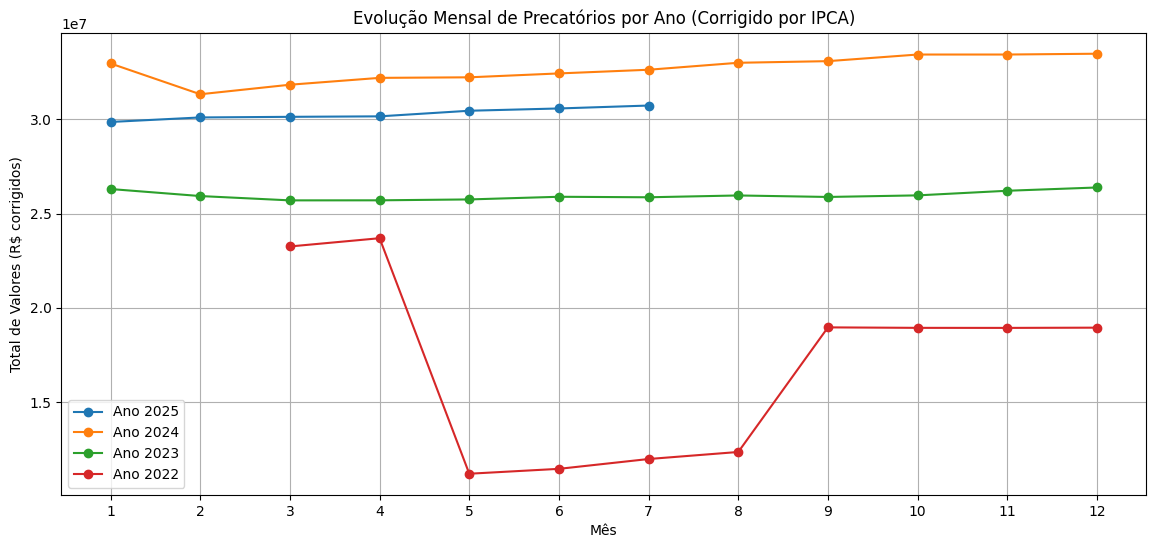

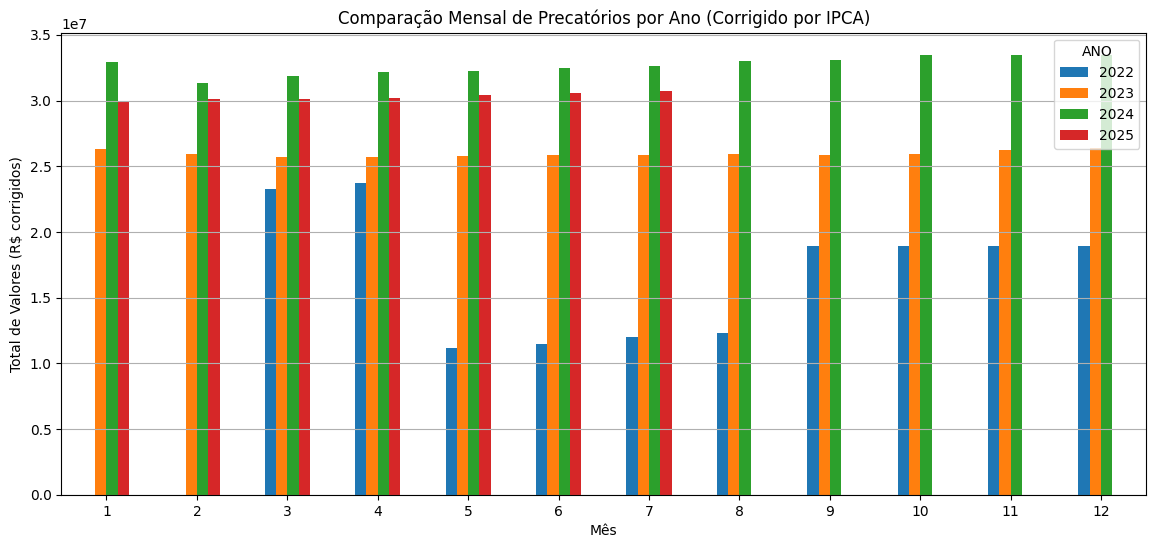

C:\Users\00526862130\AppData\Local\Temp\ipykernel_28456\1572849069.py:65: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  df_var = df_pivot.pct_change(axis=1) * 100


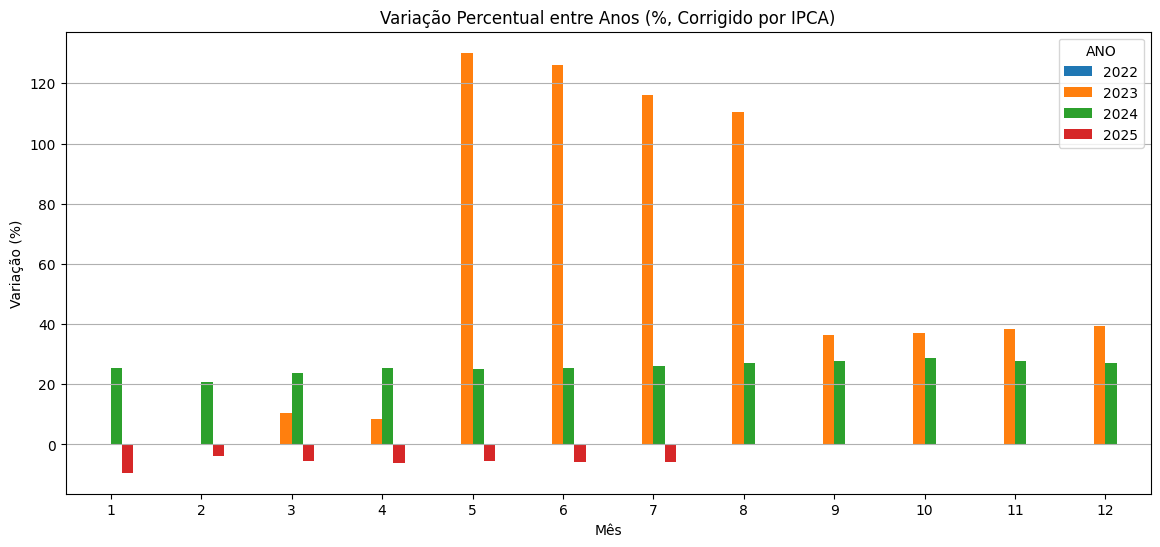

In [16]:
# Função para corrigir valores pela inflação
def corrigir_inflacao(df_precatorios, inflacao_ipca, ano_base=2025, mes_base=7):
    # Filtrar apenas o IPCA acumulado no ano
    ipca_acum = inflacao_ipca[inflacao_ipca['indicador'] == 'IPCA - Variação acumulada no ano'].copy()
    ipca_acum = ipca_acum[['ano', 'mes', 'valor']].dropna()
    
    # Calcular o fator de correção (1 + IPCA/100) para cada período
    ipca_acum['fator'] = 1 / (1 + ipca_acum['valor'] / 100)
    
    # Mesclar df_precatorios com ipca_acum para obter o fator de correção
    df_precatorios = df_precatorios.merge(
        ipca_acum[['ano', 'mes', 'fator']],
        how='left',
        left_on=[df_precatorios['DATA'].dt.year, df_precatorios['DATA'].dt.month],
        right_on=['ano', 'mes']
    )
    
    # Preencher valores ausentes de fator com 1 (caso não haja IPCA para o período)
    df_precatorios['fator'] = df_precatorios['fator'].fillna(1)
    
    # Corrigir os valores pela inflação
    df_precatorios['VALOR_CORRIGIDO'] = df_precatorios['VALOR'] * df_precatorios['fator']
    
    # Remover colunas temporárias
    df_precatorios = df_precatorios.drop(columns=['fator', 'ano', 'mes'])
    
    return df_precatorios

# Aplicar a correção pela inflação
df_precatorios = corrigir_inflacao(df_precatorios, inflacao_ipca)

# Extraindo ano e mês para conveniência
df_precatorios['ANO'] = df_precatorios['DATA'].dt.year
df_precatorios['MES'] = df_precatorios['DATA'].dt.month

# Listas de anos e meses
anos = sorted(df_precatorios['ANO'].unique(), reverse=True)
meses = range(1, 13)

# ---- Linha de evolução mensal por ano (valores corrigidos) ----
plt.figure(figsize=(14, 6))
for ano in anos:
    df_ano = df_precatorios[df_precatorios['ANO'] == ano]
    plt.plot(df_ano['MES'], df_ano['VALOR_CORRIGIDO'], marker='o', label=f"Ano {ano}")
plt.title("Evolução Mensal de Precatórios por Ano (Corrigido por IPCA)")
plt.xlabel("Mês")
plt.ylabel("Total de Valores (R$ corrigidos)")
plt.xticks(meses)
plt.grid(True)
plt.legend()
plt.show()

# ---- Comparação de barras entre anos (valores corrigidos) ----
df_pivot = df_precatorios.pivot(index='MES', columns='ANO', values='VALOR_CORRIGIDO')
df_pivot.plot(kind='bar', figsize=(14, 6))
plt.title("Comparação Mensal de Precatórios por Ano (Corrigido por IPCA)")
plt.xlabel("Mês")
plt.ylabel("Total de Valores (R$ corrigidos)")
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.show()

# ---- Variação percentual mês a mês entre anos (valores corrigidos) ----
if len(anos) > 1:
    df_var = df_pivot.pct_change(axis=1) * 100
    df_var.plot(kind='bar', figsize=(14, 6))
    plt.title("Variação Percentual entre Anos (%, Corrigido por IPCA)")
    plt.xlabel("Mês")
    plt.ylabel("Variação (%)")
    plt.xticks(rotation=0)
    plt.grid(axis='y')
    plt.show()

In [32]:
df_precatorios

,ANO,MES,VALOR,DATA,VALOR_CORRIGIDO
0,2022,3,"24,000,000",2022-03-01,"23,255,814"
1,2022,4,"24,710,333",2022-04-01,"23,693,866"
2,2022,5,"11,722,617",2022-05-01,"11,187,838"
3,2022,6,"12,075,475",2022-06-01,"11,447,033"
4,2022,7,"12,539,877",2022-07-01,"11,968,958"
5,2022,8,"12,884,343",2022-08-01,"12,342,507"
6,2022,9,"19,734,553",2022-09-01,"18,959,125"
7,2022,10,"19,823,465",2022-10-01,"18,933,586"
8,2022,11,"19,902,245",2022-11-01,"18,931,080"
9,2022,12,"20,040,801",2022-12-01,"18,943,947"
